# Satellite Data Acquisition - Quick Start: Single SAR Image Download (S1MPC)

Simple example to download a Sentinel-1 SAR image from Microsoft Planetary Computer.

Note: Sentinel-1 is a Synthetic Aperture Radar (SAR) sensor - no cloud coverage filter needed!

Author: Peter Kongstad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [3]:
# Configure logging
configure_logging(verbose=False)

## Define Area of Interest

Create a bounding box around Copenhagen.

In [4]:
# Define area as bounding box (rectangular shape)
copenhagen_center = Point(12.5683, 55.6761)  # lon, lat
buffer = 0.024  # ~5 km

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area bounds: {geometry.bounds}")
print(f"Approximate area: {(buffer * 111 * 2)**2:.1f} km²")

Area bounds: (12.544300000000002, 55.6521, 12.5923, 55.7001)
Approximate area: 28.4 km²


## Download SAR Image

Search for a recent Sentinel-1 SAR image. Note: No cloud_coverage parameter for SAR!

In [5]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Configure processing parameters (no cloud_coverage for SAR)
processing_params = ProcessingParams(
    satellite='S1MPC',
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-08-31',
    bands=['vv', 'vh'],  # SAR polarizations
    clip_method='geometry'
)

# Note: cloud_coverage parameter is automatically ignored for S1MPC

# Search and download
dataset = client.search_and_create_image(
    geometry=geometry,
    processing_params=processing_params,
    area_name='copenhagen'
)

print(f"Downloaded {len(dataset.time)} images")
print(f"Image shape: {dataset.dims}")

Downloaded 31 images
Image shape: FrozenMappingWarningOnValuesAccess({'y': 549, 'x': 329, 'time': 31})


## Visualize SAR Image

Display the VV and VH polarizations.

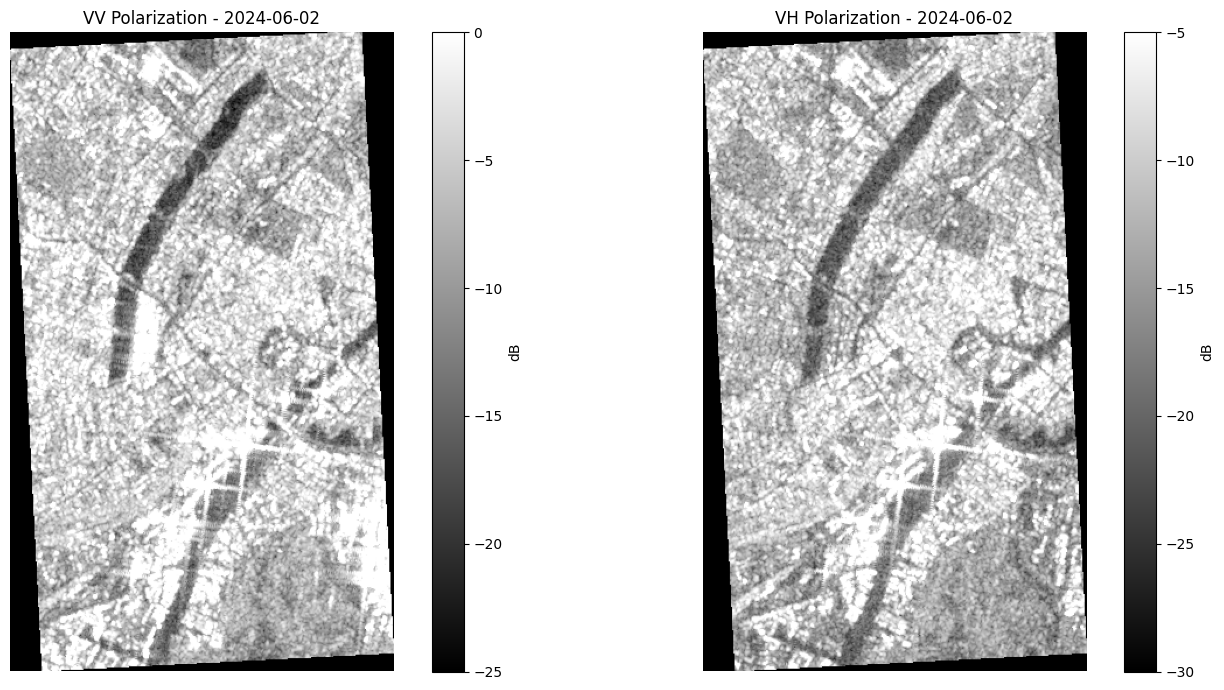

In [6]:
if len(dataset.time) > 0:
    # Get the first image
    image_slice = dataset.sel(time=dataset.time.values[0])
    
    # Extract VV and VH bands
    vv = image_slice['vv'].values
    vh = image_slice['vh'].values
    
    # Convert to dB scale for better visualization
    vv_db = 10 * np.log10(np.clip(vv, 1e-10, None))
    vh_db = 10 * np.log10(np.clip(vh, 1e-10, None))
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    date_str = str(dataset.time.values[0])[:10]
    
    im1 = axes[0].imshow(vv_db, cmap='gray', vmin=-25, vmax=0)
    axes[0].set_title(f'VV Polarization - {date_str}', fontsize=12)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], label='dB')
    
    im2 = axes[1].imshow(vh_db, cmap='gray', vmin=-30, vmax=-5)
    axes[1].set_title(f'VH Polarization - {date_str}', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], label='dB')
    
    plt.tight_layout()
    plt.show()
else:
    print("No images found for the specified criteria")

## Save to GeoTIFF

Save the downloaded SAR image to a GeoTIFF file.

In [7]:
# Configure save parameters
save_params = SaveParams(
    output_path='../data',
    save_to_local=True,
    save_as_geotiff=True,
)

if len(dataset.time) > 0:
    image_slice = dataset.sel(time=dataset.time.values[0])
    date_str = str(dataset.time.values[0])[:10]
    
    save_data(
        image=image_slice,
        identifier="copenhagen",
        datetime=date_str,
        satellite=processing_params.satellite,
        provider="MPC",
        save_params=save_params,
        band="vv_vh",
    )
    
    print(f"✓ Image saved to: ../data/S1MPC/{date_str[:4]}/tiff/")
    print(f"Filename: S1MPC_{date_str}_vv_vh_copenhagen.tif")

✓ Image saved to: ../data/S1MPC/2024/tiff/
Filename: S1MPC_2024-06-02_vv_vh_copenhagen.tif


## Next Steps

- Try the [multi_image_download.ipynb](multi_image_download.ipynb) example for time series and multiple areas
- Adjust `start_date` and `end_date` parameters
- Experiment with polarization combinations (VV, VH, VV/VH ratio)
- See [../README.md](../README.md) for more advanced features

## SAR Notes

- **VV polarization**: Better for rough surfaces (urban, water)
- **VH polarization**: Better for volume scattering (vegetation)
- **No cloud issues**: SAR can image through clouds!
- **All-weather**: Works day and night